In [2]:
# Upload 3 CSV files into Colab. Use the upload widget and pick:
# tamil_sentiment_full_train.csv
# tamil_sentiment_full_dev.csv
# tamil_sentiment_full_test.csv

from google.colab import files
import io
import pandas as pd
import os

uploaded = files.upload()  # pick the three files
uploaded = files.upload()
uploaded = files.upload()
# filenames expected
import pandas as pd

# Load datasets (simple + robust)
train_df = pd.read_csv("tamil_sentiment_full_train.csv", on_bad_lines="skip", engine="python")
dev_df   = pd.read_csv("tamil_sentiment_full_dev.csv", on_bad_lines="skip", engine="python")
test_df  = pd.read_csv("tamil_sentiment_full_test.csv", on_bad_lines="skip", engine="python")

print("Train:", train_df.shape)
print("Dev:", dev_df.shape)
print("Test:", test_df.shape)

print("\nSample train rows:")
print(train_df.head())



Saving tamil_sentiment_full_train.csv to tamil_sentiment_full_train (1).csv


Saving tamil_sentiment_full_test.csv to tamil_sentiment_full_test (1).csv


Saving tamil_sentiment_full_dev.csv to tamil_sentiment_full_dev (1).csv
Train: (32340, 1)
Dev: (4008, 1)
Test: (4049, 1)

Sample train rows:
  First like button vijay setupati fans\tunknown_state
0  Vetri ne dhanusha pudiche thongitu iru....\tPo...  
1  Ithu romba naal ku munnadi Short film'a pathat...  
2     Trending no1 in srilanka.... june 16\tPositive  
3            Maja thala marana  mass thala\tPositive  
4  Thala thala thala solla vaarthtai illai\tPositive  


In [6]:
# Cell 1: Robustly load train/dev/test CSVs (auto-detect delimiter; fallback heuristics)
import os
import pandas as pd
from collections import defaultdict

# Filenames (change if different)
TRAIN_F = "tamil_sentiment_full_train.csv"
DEV_F   = "tamil_sentiment_full_dev.csv"
TEST_F  = "tamil_sentiment_full_test.csv"

# If you prefer to upload in this cell, uncomment:
# from google.colab import files
# uploaded = files.upload()

def detect_best_delim(fname, sample_lines=5000, candidates=None):
    if candidates is None:
        candidates = ["\t", "|||", "|", ",", "\x01", ";"]
    counts = {}
    lines = []
    with open(fname, 'r', encoding='utf-8', errors='replace') as f:
        for i, L in enumerate(f):
            lines.append(L.rstrip("\n"))
            if i+1 >= sample_lines:
                break
    n = len(lines) if lines else 1
    for d in candidates:
        ok = 0
        for Ln in lines:
            parts = Ln.rsplit(d, 1)
            if len(parts) == 2 and parts[1].strip() != "":
                ok += 1
        counts[d] = ok / max(1, n)
    best = max(counts, key=counts.get)
    return best, counts

def parse_two_col_file(fname, chosen_delim=None):
    if chosen_delim is None:
        chosen_delim, counts = detect_best_delim(fname)
        print(f"Auto-detected best delim for {os.path.basename(fname)} -> {repr(chosen_delim)}; scores: {counts}")
    else:
        print(f"Using provided delim {repr(chosen_delim)} for {os.path.basename(fname)}")
    texts, labels = [], []
    skipped = 0
    with open(fname, 'r', encoding='utf-8', errors='replace') as f:
        for line in f:
            line = line.rstrip("\n")
            if not line:
                skipped += 1
                continue
            parts = line.rsplit(chosen_delim, 1)
            if len(parts) == 2 and parts[1].strip() != "":
                texts.append(parts[0].strip().strip('"'))
                labels.append(parts[1].strip().strip('"'))
            else:
                # fallback attempts
                fallback_done = False
                for d in ["\t", "|", ","]:
                    p2 = line.rsplit(d, 1)
                    if len(p2) == 2 and p2[1].strip() != "":
                        texts.append(p2[0].strip().strip('"'))
                        labels.append(p2[1].strip().strip('"'))
                        fallback_done = True
                        break
                if not fallback_done:
                    skipped += 1
    df = pd.DataFrame({"text": texts, "label": labels})
    df = df[df["label"].astype(str).str.strip() != ""].reset_index(drop=True)
    return df, skipped

# Parse files (require files be present in the working dir)
parsed = {}
for fname in (TRAIN_F, DEV_F, TEST_F):
    if not os.path.exists(fname):
        raise FileNotFoundError(f"File not found in working dir: {fname}. Upload or change path.")
    best, counts = detect_best_delim(fname, sample_lines=5000)
    print(f"\n{fname} delimiter scores (frac of lines splitting into two parts using rsplit):")
    for d, frac in counts.items():
        print(f"  {repr(d):6} -> {frac:.3f}")
    df, skipped = parse_two_col_file(fname, chosen_delim=best)
    print(f"Parsed {len(df)} rows from {fname}; skipped {skipped} malformed/empty lines.")
    if len(df) == 0:
        raise RuntimeError(f"No rows parsed from {fname}. Inspect file manually.")
    parsed[fname] = df
    display(df.head(3))
    print("Label distribution (top 10):")
    display(df['label'].value_counts().head(10))

# Assign to variables used later
train_df = parsed[TRAIN_F]
dev_df   = parsed[DEV_F]
test_df  = parsed[TEST_F]

print("\nFinal shapes:")
print("train:", train_df.shape)
print("dev:  ", dev_df.shape)
print("test: ", test_df.shape)


tamil_sentiment_full_train.csv delimiter scores (frac of lines splitting into two parts using rsplit):
  '\t'   -> 1.000
  '|||'  -> 0.000
  '|'    -> 0.001
  ','    -> 0.080
  '\x01' -> 0.000
  ';'    -> 0.000
Using provided delim '\t' for tamil_sentiment_full_train.csv
Parsed 35219 rows from tamil_sentiment_full_train.csv; skipped 1 malformed/empty lines.


,text,label
0,First like button vijay setupati fans,unknown_state
1,Vetri ne dhanusha pudiche thongitu iru....,Positive
2,Ithu romba naal ku munnadi Short film'a pathat...,Positive


Label distribution (top 10):


,count
label,
Positive,19922
unknown_state,5544
Negative,4160
Mixed_feelings,3907
not-Tamil,1686



tamil_sentiment_full_dev.csv delimiter scores (frac of lines splitting into two parts using rsplit):
  '\t'   -> 0.000
  '|||'  -> 0.000
  '|'    -> 0.000
  ','    -> 0.086
  '\x01' -> 0.000
  ';'    -> 0.000
Using provided delim ',' for tamil_sentiment_full_dev.csv
Parsed 379 rows from tamil_sentiment_full_dev.csv; skipped 4019 malformed/empty lines.


,text,label
0,34k dislikes...... Vera edhum illa....ellame v...,haters...athhaa..... vekkam kettavargal;Negative;
1,Mairu mari iruku trailer,idhuku teaser thevalam.;Positive;
2,1:36 U kena tunggu lebih lama lagi,untuk tahu saya...;Negative;


Label distribution (top 10):


,count
label,
;Positive;,9
;Mixed_feelings;,6
;Negative;,5
6381722715;unknown_state;,2
#ZAYEDMASOOD mmade Rajuettan;not-Tamil;,2
serupadi kudukum vagaiyil amathirukirathu.... Intha padam vetrinadai poda valthukal.......;Positive;,1
str elarum Yaru andha savuku karanamnu kandupudipaga Vijay sedhupathi um Idhula travel panuvaga kadasi Oru trust varum arrivind swamy tha kolapaniruparu;Negative;,1
வாழ்த்துக்கள்;not-Tamil;,1
vankodama sattatha pathi konjam sollunga atha thappa use pandranga yengala mari niraya peru antha sattathala padhika pattu erukaranga;Positive;,1



tamil_sentiment_full_test.csv delimiter scores (frac of lines splitting into two parts using rsplit):
  '\t'   -> 0.000
  '|||'  -> 0.000
  '|'    -> 0.000
  ','    -> 0.077
  '\x01' -> 0.000
  ';'    -> 0.000
Using provided delim ',' for tamil_sentiment_full_test.csv
Parsed 340 rows from tamil_sentiment_full_test.csv; skipped 4062 malformed/empty lines.


,text,label
0,Trailer enna,trending layae varala ?🤔 Ennachu !!;Negative;
1,"Evergreen superstar ,thalaivar mass intha vaya...",thalaivar unmayilaiye marana mass.;Positive;
2,Indha Kadhai la Hero yaaru Villain yaaru... Or...,AravindSwamy);Mixed_feelings;


Label distribution (top 10):


,count
label,
;Positive;,7
;Negative;,4
;unknown_state;,3
;not-Tamil;,2
heroine aah pottirkalaam !! :/ -_-;Mixed_feelings;,1
052 dislikes ??;unknown_state;,1
tube light and naan sirithal maritha irukum pola;Positive;,1
வெற்றி பெற என் aasirvathangal.;Positive;,1
vinod .. Idhuku mela ena venum;Positive;,1



Final shapes:
train: (35219, 2)
dev:   (379, 2)
test:  (340, 2)


In [8]:
# Run this to inspect and clean labels in dev/test so LabelEncoder.transform() works
import re
from collections import Counter
import pandas as pd

def show_label_overview(train_df, dev_df, test_df, label_col="label", top_n=30):
    print("TRAIN unique labels (sample up to {}):".format(top_n))
    print(train_df[label_col].value_counts().head(top_n))
    print("\nDEV unique labels (sample up to {}):".format(top_n))
    print(dev_df[label_col].value_counts().head(top_n))
    print("\nTEST unique labels (sample up to {}):".format(top_n))
    print(test_df[label_col].value_counts().head(top_n))

show_label_overview(train_df, dev_df, test_df, label_col="label", top_n=30)

# --- Cleaning function ---
def clean_label_raw(lbl):
    if pd.isna(lbl):
        return ""
    s = str(lbl).strip()
    # remove surrounding quotes and stray control characters
    s = s.strip('"').strip("'").strip()
    # collapse multiple spaces
    s = re.sub(r'\s+', ' ', s)
    # remove stray leading/trailing punctuation except internal ones
    s = s.strip(" \t\n\r;|,")
    return s

def extract_label(lbl, known_labels):
    """
    Attempts to map a raw label string to one of known_labels.
    Strategy:
      1. Basic cleaning (strip quotes/semicolons)
      2. If exact match (case-insensitive) -> return known label
      3. Split on common delimiters and take last piece -> try match
      4. Search for any known_label as substring (case-insensitive) inside lbl
      5. If none found, return None
    """
    if lbl is None:
        return None
    s = clean_label_raw(lbl)
    if s == "":
        return None
    # exact match (case-insensitive)
    for kl in known_labels:
        if s.lower() == kl.lower():
            return kl
    # split on common separators and test the last token
    parts = re.split(r'[;|\t,/:]+', s)
    if len(parts) > 1:
        candidate = parts[-1].strip()
        for kl in known_labels:
            if candidate.lower() == kl.lower():
                return kl
    # try substring match (pick first known label that appears inside s)
    for kl in known_labels:
        if kl.lower() in s.lower():
            return kl
    # sometimes labels are wrapped like '...;Negative;' or 'Positive; ' (take token that matches pattern)
    # final fallback: try to find a single word token equal to known label
    tokens = re.findall(r"[A-Za-z]+", s)
    for t in tokens[::-1]:  # try last tokens first
        for kl in known_labels:
            if t.lower() == kl.lower():
                return kl
    return None

# --- Build set of known labels from train (cleaned) ---
known_train = sorted({clean_label_raw(x) for x in train_df['label'].unique() if str(x).strip()!=""})
print("\nKnown train labels (cleaned):", known_train)

# --- Apply mapping to dev and test, collecting unmapped examples ---
def map_labels(df, known_train):
    mapped = []
    unmapped_examples = {}
    for i, raw in enumerate(df['label'].astype(str).tolist()):
        mapped_label = extract_label(raw, known_train)
        if mapped_label is None:
            # store first few unmapped samples for inspection
            if len(unmapped_examples) < 20:
                unmapped_examples[len(unmapped_examples)] = raw
            mapped.append(None)
        else:
            mapped.append(mapped_label)
    df['label_mapped'] = mapped
    return df, unmapped_examples

dev_df, dev_unmapped = map_labels(dev_df, known_train)
test_df, test_unmapped = map_labels(test_df, known_train)

print(f"\nDEV unmapped examples (up to 20): {len(dev_unmapped)}")
for k,v in dev_unmapped.items():
    print(" -", v)
print(f"\nTEST unmapped examples (up to 20): {len(test_unmapped)}")
for k,v in test_unmapped.items():
    print(" -", v)

# Option: drop unmapped rows (safe), or keep them as 'UNKNOWN' label.
DROP_UNMAPPED = True

if DROP_UNMAPPED:
    before = dev_df.shape[0]
    dev_df = dev_df[dev_df['label_mapped'].notna()].reset_index(drop=True)
    after = dev_df.shape[0]
    print(f"\nDropped {before-after} unmapped rows from dev_df")
    before = test_df.shape[0]
    test_df = test_df[test_df['label_mapped'].notna()].reset_index(drop=True)
    after = test_df.shape[0]
    print(f"Dropped {before-after} unmapped rows from test_df")
else:
    # fill with a fallback label if desired (uncomment to map to a fallback)
    # fallback = known_train[0]  # e.g. most frequent class
    # dev_df['label_mapped'].fillna(fallback, inplace=True)
    pass

# Replace original label column with mapped cleaned labels for downstream pipeline
dev_df['label'] = dev_df['label_mapped'].astype(str)
test_df['label'] = test_df['label_mapped'].astype(str)
dev_df.drop(columns=['label_mapped'], inplace=True)
test_df.drop(columns=['label_mapped'], inplace=True)

# Re-run label encoding safely
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(train_df['label'].astype(str))
# Now dev/test only contain labels that exist in train (unless you chose to map unmapped differently)
y_dev = le.transform(dev_df['label'].astype(str))
y_test = le.transform(test_df['label'].astype(str))

print("\nAfter mapping:")
print("Train label counts:", Counter(y_train))
print("Dev label counts:", Counter(y_dev))
print("Test label counts:", Counter(y_test))

# If you dropped unmapped rows above, make sure to use updated dev_df/test_df in later steps.
print("\nUse the updated dev_df and test_df for tokenization/training steps.")

TRAIN unique labels (sample up to 30):
label
Positive          19922
unknown_state      5544
Negative           4160
Mixed_feelings     3907
not-Tamil          1686
Name: count, dtype: int64

DEV unique labels (sample up to 30):
label
;Positive;                                                                                                                                                                                                                  9
;Mixed_feelings;                                                                                                                                                                                                            6
;Negative;                                                                                                                                                                                                                  5
6381722715;unknown_state;                                                                          

In [9]:
# Cell 3: Tokenizer, padding, and embedding config
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_NUM_WORDS = 30000
MAX_SEQ_LEN = 80
EMBEDDING_DIM = 128

all_texts = pd.concat([train_df["text"], dev_df["text"], test_df["text"]]).astype(str).tolist()
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(all_texts)
vocab_size = min(MAX_NUM_WORDS, len(tokenizer.word_index) + 1)
print("Vocab size:", vocab_size)

def texts_to_padded(series):
    seqs = tokenizer.texts_to_sequences(series.astype(str).tolist())
    return pad_sequences(seqs, maxlen=MAX_SEQ_LEN, padding="post", truncating="post")

X_train = texts_to_padded(train_df["text"])
X_dev   = texts_to_padded(dev_df["text"])
X_test  = texts_to_padded(test_df["text"])

print("Shapes ->", X_train.shape, X_dev.shape, X_test.shape)

Vocab size: 30000
Shapes -> (35219, 80) (378, 80) (340, 80)


In [11]:
# Cell 4: Build BiLSTM, train, evaluate
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.metrics import f1_score, accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import random

# Config
BATCH_SIZE = 64
EPOCHS = 6
RUNS = 1            # change to 3 if you want three runs
RUN_SEEDS = [42, 1234, 2025][:RUNS]
USE_CLASS_WEIGHT = True   # set False to disable

# ✅ define num_classes here
num_classes = len(le.classes_)
print("num_classes =", num_classes)

def build_model(vocab_size=vocab_size, embedding_dim=EMBEDDING_DIM, max_seq_len=MAX_SEQ_LEN, num_classes=num_classes):
    inp = layers.Input(shape=(max_seq_len,), dtype="int32")
    x = layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_seq_len)(inp)
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(64))(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.4)(x)
    if num_classes == 2:
        out = layers.Dense(1, activation="sigmoid")(x)
        loss = "binary_crossentropy"
    else:
        out = layers.Dense(num_classes, activation="softmax")(x)
        loss = "sparse_categorical_crossentropy"
    model = models.Model(inp, out)
    model.compile(optimizer=optimizers.Adam(1e-3), loss=loss, metrics=["accuracy"])
    return model

num_classes = 5


In [12]:
# Cell 4: Build BiLSTM, train (RUNS adjustable), evaluate (weighted F1)
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.metrics import f1_score, accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import random

# Config
BATCH_SIZE = 64
EPOCHS = 6
RUNS = 1            # set to 3 if you want three runs
RUN_SEEDS = [42, 1234, 2025][:RUNS]
USE_CLASS_WEIGHT = True   # set False to disable

def build_model(vocab_size=vocab_size, embedding_dim=EMBEDDING_DIM, max_seq_len=MAX_SEQ_LEN, num_classes=num_classes):
    inp = layers.Input(shape=(max_seq_len,), dtype="int32")
    x = layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_seq_len)(inp)
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(64))(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.4)(x)
    if num_classes == 2:
        out = layers.Dense(1, activation="sigmoid")(x)
        loss = "binary_crossentropy"
    else:
        out = layers.Dense(num_classes, activation="softmax")(x)
        loss = "sparse_categorical_crossentropy"
    model = models.Model(inp, out)
    model.compile(optimizer=optimizers.Adam(1e-3), loss=loss, metrics=["accuracy"])
    return model

# compute class weights if enabled
class_weight = None
if USE_CLASS_WEIGHT:
    classes = np.unique(y_train)
    cw = compute_class_weight("balanced", classes=classes, y=y_train)
    class_weight = {int(c): float(w) for c,w in zip(classes, cw)}
    print("Using class_weight:", class_weight)

run_results = []
for run_idx, seed in enumerate(RUN_SEEDS, start=1):
    print(f"\n=== RUN {run_idx} seed={seed} ===")
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    model = build_model()
    model.summary()

    cbs = [callbacks.EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)]
    history = model.fit(
        X_train, y_train,
        validation_data=(X_dev, y_dev),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=cbs,
        verbose=2,
        class_weight=class_weight if USE_CLASS_WEIGHT else None
    )

    # predict & evaluate
    probs = model.predict(X_test, verbose=0)
    if num_classes == 2:
        preds = (probs > 0.5).astype(int).reshape(-1)
    else:
        preds = np.argmax(probs, axis=1)

    acc = accuracy_score(y_test, preds)
    w_f1 = f1_score(y_test, preds, average="weighted")
    print(f"Run {run_idx} -> accuracy: {acc:.4f}, weighted F1: {w_f1:.4f}")
    print("\nClassification report:")
    print(classification_report(y_test, preds, target_names=list(le.classes_), digits=4))

    run_results.append({"run": run_idx, "seed": seed, "accuracy": acc, "weighted_f1": w_f1})

Using class_weight: {0: 1.8028666496032761, 1: 1.693221153846154, 2: 0.3535689187832547, 3: 4.177817319098458, 4: 1.2705266955266956}

=== RUN 1 seed=42 ===


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 80, 128)        │     3,840,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 80, 256)        │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,276,101 (16.31 MB)

 Trainable params: 4,276,101 (16.31 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/6
551/551 - 19s - 34ms/step - accuracy: 0.4358 - loss: 1.3202 - val_accuracy: 0.3995 - val_loss: 1.4004
Epoch 2/6
551/551 - 17s - 30ms/step - accuracy: 0.6138 - loss: 0.9689 - val_accuracy: 0.3704 - val_loss: 1.5134
Epoch 3/6
551/551 - 21s - 37ms/step - accuracy: 0.7222 - loss: 0.7043 - val_accuracy: 0.3915 - val_loss: 1.6769
Run 1 -> accuracy: 0.4294, weighted F1: 0.4627

Classification report:
                precision    recall  f1-score   support

Mixed_feelings     0.3279    0.3448    0.3361        58
      Negative     0.4630    0.5102    0.4854        49
      Positive     0.7524    0.4620    0.5725       171
     not-Tamil     0.1159    0.8000    0.2025        10
 unknown_state     0.2745    0.2692    0.2718        52

      accuracy                         0.4294       340
     macro avg     0.3867    0.4773    0.3737       340
  weighted avg     0.5464    0.4294    0.4627       340



In [13]:
# Cell 5: show summary table
import pandas as pd
summary_df = pd.DataFrame(run_results)
print("\nSummary of runs:")
display(summary_df)
# Optionally save summary to CSV
summary_df.to_csv("runs_summary.csv", index=False)
print("Saved runs_summary.csv to working directory.")


Summary of runs:


,run,seed,accuracy,weighted_f1
0,1,42,0.429412,0.462749


Saved runs_summary.csv to working directory.


In [14]:
# Cell A: Define a simple attention layer and build attention-BiLSTM model
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

# Simple attention layer (dot-product style with trainable projection)
class AttentionLayer(layers.Layer):
    def __init__(self, units=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units

    def build(self, input_shape):
        # input_shape: (batch, time, features)
        feat_dim = int(input_shape[-1])
        if self.units is None:
            self.units = feat_dim
        # trainable weight to project features for attention score
        self.W = self.add_weight(shape=(feat_dim, self.units),
                                 initializer="glorot_uniform",
                                 trainable=True, name="W_att")
        self.v = self.add_weight(shape=(self.units, 1),
                                 initializer="glorot_uniform",
                                 trainable=True, name="v_att")
        super().build(input_shape)

    def call(self, inputs, mask=None):
        # inputs: (batch, time, feat)
        # score = v^T * tanh(inputs @ W)
        proj = tf.tanh(tf.tensordot(inputs, self.W, axes=1))  # (batch, time, units)
        score = tf.tensordot(proj, self.v, axes=1)            # (batch, time, 1)
        score = tf.squeeze(score, axis=-1)                    # (batch, time)
        if mask is not None:
            # mask shape (batch, time) boolean
            score = tf.where(mask, score, tf.fill(tf.shape(score), -1e9))
        att_weights = tf.nn.softmax(score, axis=-1)           # (batch, time)
        att_weights_expanded = tf.expand_dims(att_weights, axis=-1)  # (batch, time, 1)
        context = tf.reduce_sum(inputs * att_weights_expanded, axis=1)  # (batch, feat)
        return context

    def get_config(self):
        cfg = super().get_config()
        cfg.update({"units": self.units})
        return cfg

# Build function for attention-BiLSTM
def build_attention_bilstm(vocab_size, max_seq_len=80, embedding_dim=128, num_classes=2, dropout=0.4):
    inp = layers.Input(shape=(max_seq_len,), dtype="int32", name="input_ids")
    x = layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_seq_len, name="embedding")(inp)
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True), name="bilstm1")(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True), name="bilstm2")(x)
    # apply attention on top of sequence outputs
    context = AttentionLayer()(x)   # (batch, features)
    x = layers.Dense(64, activation="relu")(context)
    x = layers.Dropout(dropout)(x)
    if num_classes == 2:
        out = layers.Dense(1, activation="sigmoid", name="out")(x)
        loss = "binary_crossentropy"
    else:
        out = layers.Dense(num_classes, activation="softmax", name="out")(x)
        loss = "sparse_categorical_crossentropy"
    model = models.Model(inputs=inp, outputs=out)
    model.compile(optimizer=optimizers.Adam(1e-3), loss=loss, metrics=["accuracy"])
    return model

# basic test if needed (skips if vocab_size not present)
try:
    _ = vocab_size  # if defined earlier
    _model = build_attention_bilstm(vocab_size=vocab_size, max_seq_len=MAX_SEQ_LEN,
                                   embedding_dim=EMBEDDING_DIM, num_classes=(len(getattr(le,'classes_',[])) or 2))
    print("Attention-BiLSTM model built successfully.")
    _model.summary()
except Exception as e:
    print("Model built-check skipped (vocab_size/MAX_SEQ_LEN/EMBEDDING_DIM may not be defined). Error:", e)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Attention-BiLSTM model built successfully.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)          │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 80, 128)        │     3,840,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bilstm1 (Bidirectional)         │ (None, 80, 256)        │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bilstm2 (Bidirectional)         │ (None, 80, 128)        │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer                 │ (None, 128)            │        16,512 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ out (Dense)                     │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,292,613 (16.38 MB)

 Trainable params: 4,292,613 (16.38 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Cell B: Prepare X/y arrays or tf.data datasets (will use X_train etc. if present)
import numpy as np
from sklearn.preprocessing import LabelEncoder

# If variables don't exist, try to create them from train_df/dev_df/test_df
needed = ["X_train","X_dev","X_test","y_train","y_dev","y_test","vocab_size","MAX_SEQ_LEN","EMBEDDING_DIM","tokenizer","le"]
missing = [n for n in needed if n not in globals()]
if missing:
    print("Some expected preprocessing variables were missing:", missing)
    # try to recreate minimal ones if train_df exists
    if "train_df" in globals() and "dev_df" in globals() and "test_df" in globals():
        print("Recreating tokenizer/padded sequences from train_df/dev_df/test_df.")
        from tensorflow.keras.preprocessing.text import Tokenizer
        from tensorflow.keras.preprocessing.sequence import pad_sequences
        # fallbacks
        MAX_NUM_WORDS = globals().get("MAX_NUM_WORDS", 30000)
        MAX_SEQ_LEN = globals().get("MAX_SEQ_LEN", 80)
        EMBEDDING_DIM = globals().get("EMBEDDING_DIM", 128)
        tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
        all_texts = list(train_df["text"].astype(str)) + list(dev_df["text"].astype(str)) + list(test_df["text"].astype(str))
        tokenizer.fit_on_texts(all_texts)
        vocab_size = min(MAX_NUM_WORDS, len(tokenizer.word_index) + 1)
        def texts_to_padded(series):
            seqs = tokenizer.texts_to_sequences(series.astype(str).tolist())
            return pad_sequences(seqs, maxlen=MAX_SEQ_LEN, padding="post", truncating="post")
        X_train = texts_to_padded(train_df["text"])
        X_dev   = texts_to_padded(dev_df["text"])
        X_test  = texts_to_padded(test_df["text"])
        le = LabelEncoder()
        y_train = le.fit_transform(train_df["label"].astype(str))
        y_dev   = le.transform(dev_df["label"].astype(str))
        y_test  = le.transform(test_df["label"].astype(str))
        print("Recreated X/y arrays and tokenizer.")
    else:
        raise RuntimeError("Missing preprocessing variables and no train_df/dev_df/test_df available to rebuild them. Please run preprocessing cells first.")

# Convert to tf.data for better perf (optional)
USE_TFDATA = True
BATCH_SIZE = globals().get("BATCH_SIZE", 64)
if USE_TFDATA:
    import tensorflow as tf
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(20000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    dev_ds   = tf.data.Dataset.from_tensor_slices((X_dev, y_dev)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    test_ds  = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    print("Built tf.data datasets: train_ds/dev_ds/test_ds")
else:
    train_ds = (X_train, y_train)
    dev_ds = (X_dev, y_dev)
    test_ds = (X_test, y_test)
    print("Using numpy arrays for training.")

Built tf.data datasets: train_ds/dev_ds/test_ds


In [16]:
# Cell C: Train & evaluate attention BiLSTM; prints weighted F1 and classification report
import numpy as np
import random
import tensorflow as tf
from sklearn.metrics import f1_score, accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight

# Config
RUNS = 1            # change to 3 for three independent runs
RUN_SEEDS = [42, 1234, 2025][:RUNS]
EPOCHS = 6
BATCH_SIZE = globals().get("BATCH_SIZE", 64)
USE_CLASS_WEIGHT = True
VERBOSE = 2

num_classes = len(getattr(le, "classes_", np.unique(y_train)))
print("num_classes:", num_classes)

# compute class weights (if desired)
class_weight = None
if USE_CLASS_WEIGHT:
    classes = np.unique(y_train)
    cw = compute_class_weight("balanced", classes=classes, y=y_train)
    class_weight = {int(c): float(w) for c,w in zip(classes, cw)}
    print("Class weights:", class_weight)

run_results = []
for run_idx, seed in enumerate(RUN_SEEDS, start=1):
    print(f"\n=== RUN {run_idx} (seed={seed}) ===")
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    model = build_attention_bilstm(vocab_size=vocab_size, max_seq_len=MAX_SEQ_LEN,
                                  embedding_dim=EMBEDDING_DIM, num_classes=num_classes)
    model.summary()

    # timing callback (prints ETA)
    import time
    class EpochTimerCallback(tf.keras.callbacks.Callback):
        def on_train_begin(self, logs=None):
            self.epoch_times = []
            self.start_time = time.time()
        def on_epoch_begin(self, epoch, logs=None):
            self.epoch_start = time.time()
        def on_epoch_end(self, epoch, logs=None):
            t = time.time() - self.epoch_start
            self.epoch_times.append(t)
            avg = np.mean(self.epoch_times)
            elapsed = time.time() - self.start_time
            epochs_done = len(self.epoch_times)
            epochs_total = self.params.get('epochs', epochs_done)
            epochs_left = max(0, epochs_total - epochs_done)
            eta_sec = epochs_left * avg
            def fmt(s):
                m, s = divmod(int(s), 60)
                h, m = divmod(m, 60)
                return f"{h:d}h {m:02d}m {s:02d}s" if h>0 else f"{m:02d}m {s:02d}s"
            print(f"\nEpoch {epoch+1} time: {t:.2f}s — avg: {avg:.2f}s — elapsed: {fmt(elapsed)} — ETA: {fmt(eta_sec)}")

    cbs = [EpochTimerCallback(), tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)]

    # fit (use tf.data if built)
    if isinstance(train_ds, tf.data.Dataset):
        model.fit(train_ds, validation_data=dev_ds, epochs=EPOCHS, callbacks=cbs, verbose=VERBOSE, class_weight=(class_weight if USE_CLASS_WEIGHT else None))
        probs = model.predict(test_ds, verbose=0)
    else:
        model.fit(X_train, y_train, validation_data=(X_dev, y_dev), epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=cbs, verbose=VERBOSE, class_weight=(class_weight if USE_CLASS_WEIGHT else None))
        probs = model.predict(X_test, batch_size=BATCH_SIZE, verbose=0)

    # convert probs -> preds
    if num_classes == 2:
        preds = (probs > 0.5).astype(int).reshape(-1)
    else:
        preds = np.argmax(probs, axis=1)

    acc = accuracy_score(y_test, preds)
    w_f1 = f1_score(y_test, preds, average="weighted")
    print(f"\nRun {run_idx} -> accuracy: {acc:.4f}, weighted F1: {w_f1:.4f}")
    print("\nClassification report:")
    print(classification_report(y_test, preds, target_names=list(getattr(le,"classes_",[])), digits=4))

    run_results.append({"run": run_idx, "seed": seed, "accuracy": float(acc), "weighted_f1": float(w_f1)})

num_classes: 5
Class weights: {0: 1.8028666496032761, 1: 1.693221153846154, 2: 0.3535689187832547, 3: 4.177817319098458, 4: 1.2705266955266956}

=== RUN 1 (seed=42) ===


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)          │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 80, 128)        │     3,840,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bilstm1 (Bidirectional)         │ (None, 80, 256)        │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bilstm2 (Bidirectional)         │ (None, 80, 128)        │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer_1               │ (None, 128)            │        16,512 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ out (Dense)                     │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,292,613 (16.38 MB)

 Trainable params: 4,292,613 (16.38 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/6

Epoch 1 time: 17.64s — avg: 17.64s — elapsed: 00m 17s — ETA: 01m 28s
551/551 - 18s - 32ms/step - accuracy: 0.4292 - loss: 1.3861 - val_accuracy: 0.3995 - val_loss: 1.3857
Epoch 2/6

Epoch 2 time: 19.71s — avg: 18.67s — elapsed: 00m 37s — ETA: 01m 14s
551/551 - 20s - 36ms/step - accuracy: 0.6047 - loss: 1.0218 - val_accuracy: 0.4233 - val_loss: 1.3758
Epoch 3/6

Epoch 3 time: 12.26s — avg: 16.54s — elapsed: 00m 49s — ETA: 00m 49s
551/551 - 12s - 22ms/step - accuracy: 0.7137 - loss: 0.7273 - val_accuracy: 0.3810 - val_loss: 1.5455
Epoch 4/6

Epoch 4 time: 20.60s — avg: 17.55s — elapsed: 01m 10s — ETA: 00m 35s
551/551 - 21s - 37ms/step - accuracy: 0.7910 - loss: 0.5187 - val_accuracy: 0.4101 - val_loss: 1.7719

Run 1 -> accuracy: 0.4206, weighted F1: 0.4469

Classification report:
                precision    recall  f1-score   support

Mixed_feelings     0.2917    0.2414    0.2642        58
      Negative     0.3235    0.4490    0.3761        49
      Positive     0.7339    0.

In [17]:
# Cell D: Show run summary table
import pandas as pd
summary_df = pd.DataFrame(run_results)
print("Run summary:")
display(summary_df)
# Save optionally
# summary_df.to_csv("attention_bilstm_runs_summary.csv", index=False)

Run summary:


,run,seed,accuracy,weighted_f1
0,1,42,0.420588,0.446854


In [18]:
# Cell 1: Define hybrid CNN + BiLSTM model builder
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

def build_hybrid_cnn_bilstm(vocab_size,
                           max_seq_len=80,
                           embedding_dim=128,
                           num_classes=2,
                           cnn_filters=128,
                           cnn_kernel_sizes=(3,4,5),
                           lstm_units=128,
                           dropout=0.4):
    """
    Hybrid model: CNN (multiple kernel sizes) -> pooled features + BiLSTM -> concat -> classification head.
    """
    inp = layers.Input(shape=(max_seq_len,), dtype="int32", name="input_ids")
    x = layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_seq_len, name="embedding")(inp)

    # CNN parallel convs
    conv_pools = []
    for k in cnn_kernel_sizes:
        c = layers.Conv1D(filters=cnn_filters, kernel_size=k, padding="valid", activation="relu")(x)
        p = layers.GlobalMaxPool1D()(c)
        conv_pools.append(p)
    cnn_feat = layers.Concatenate()(conv_pools) if len(conv_pools) > 1 else conv_pools[0]

    # BiLSTM on sequence (return last state)
    lstm_out = layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=False))(x)

    # concat
    merged = layers.Concatenate()([cnn_feat, lstm_out])
    merged = layers.Dense(128, activation="relu")(merged)
    merged = layers.Dropout(dropout)(merged)

    if num_classes == 2:
        out = layers.Dense(1, activation="sigmoid", name="out")(merged)
        loss = "binary_crossentropy"
    else:
        out = layers.Dense(num_classes, activation="softmax", name="out")(merged)
        loss = "sparse_categorical_crossentropy"

    model = models.Model(inputs=inp, outputs=out)
    model.compile(optimizer=optimizers.Adam(1e-3), loss=loss, metrics=["accuracy"])
    return model

# quick sanity: only run summary if vocab_size is set
try:
    _ = vocab_size
    _ = MAX_SEQ_LEN
    _ = EMBEDDING_DIM
    _model = build_hybrid_cnn_bilstm(vocab_size=vocab_size, max_seq_len=MAX_SEQ_LEN,
                                    embedding_dim=EMBEDDING_DIM, num_classes=max(2, len(getattr(le,'classes_',[]))))
    print("Hybrid CNN+BiLSTM model built; summary:")
    _model.summary()
except Exception as e:
    print("Model summary skipped because preprocessing vars may not be present. Error:", e)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Hybrid CNN+BiLSTM model built; summary:


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ids           │ (None, 80)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 80, 128)   │  3,840,000 │ input_ids[0][0]   │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 78, 128)   │     49,280 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 77, 128)   │     65,664 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 76, 128)   │     82,048 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d[0][0]      │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_1[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_2[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 384)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 256)       │    263,168 │ embedding[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 640)       │          0 │ concatenate[0][0… │
│ (Concatenate)       │                   │            │ bidirectional_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │     82,048 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ out (Dense)         │ (None, 5)         │        645 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,382,853 (16.72 MB)

 Trainable params: 4,382,853 (16.72 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Cell 2: Ensure X_train, X_dev, X_test, y_train, y_dev, y_test, tokenizer, vocab_size exist.
import numpy as np
from sklearn.preprocessing import LabelEncoder

needed = ["X_train","X_dev","X_test","y_train","y_dev","y_test","vocab_size","MAX_SEQ_LEN","EMBEDDING_DIM","tokenizer","le"]
missing = [n for n in needed if n not in globals()]
if missing:
    print("Missing variables:", missing)
    if "train_df" in globals() and "dev_df" in globals() and "test_df" in globals():
        print("Recreating tokenizer/padded sequences from train_df/dev_df/test_df.")
        from tensorflow.keras.preprocessing.text import Tokenizer
        from tensorflow.keras.preprocessing.sequence import pad_sequences
        MAX_NUM_WORDS = globals().get("MAX_NUM_WORDS", 30000)
        MAX_SEQ_LEN = globals().get("MAX_SEQ_LEN", 80)
        EMBEDDING_DIM = globals().get("EMBEDDING_DIM", 128)
        tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
        all_texts = list(train_df["text"].astype(str)) + list(dev_df["text"].astype(str)) + list(test_df["text"].astype(str))
        tokenizer.fit_on_texts(all_texts)
        vocab_size = min(MAX_NUM_WORDS, len(tokenizer.word_index) + 1)
        def texts_to_padded(series):
            seqs = tokenizer.texts_to_sequences(series.astype(str).tolist())
            from tensorflow.keras.preprocessing.sequence import pad_sequences
            return pad_sequences(seqs, maxlen=MAX_SEQ_LEN, padding="post", truncating="post")
        X_train = texts_to_padded(train_df["text"])
        X_dev   = texts_to_padded(dev_df["text"])
        X_test  = texts_to_padded(test_df["text"])
        le = LabelEncoder()
        y_train = le.fit_transform(train_df["label"].astype(str))
        y_dev   = le.transform(dev_df["label"].astype(str))
        y_test  = le.transform(test_df["label"].astype(str))
        print("Recreated arrays: X_train/dev/test shapes:", X_train.shape, X_dev.shape, X_test.shape)
    else:
        raise RuntimeError("Missing preprocessing variables and no train_df/dev_df/test_df available. Run preprocessing first.")

# Build tf.data Datasets for speed
USE_TFDATA = True
BATCH_SIZE = globals().get("BATCH_SIZE", 64)
if USE_TFDATA:
    import tensorflow as tf
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(20000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    dev_ds   = tf.data.Dataset.from_tensor_slices((X_dev, y_dev)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    test_ds  = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    print("tf.data datasets built: train/dev/test")
else:
    train_ds = (X_train, y_train)
    dev_ds = (X_dev, y_dev)
    test_ds = (X_test, y_test)
    print("Using numpy arrays for training.")

tf.data datasets built: train/dev/test


In [20]:
# Cell 3: Train hybrid model and evaluate (weighted F1). No model saving.
import numpy as np
import random
import tensorflow as tf
from sklearn.metrics import f1_score, accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight

# CONFIG
RUNS = 1            # set to 3 for three independent runs
RUN_SEEDS = [42, 1234, 2025][:RUNS]
EPOCHS = 6
BATCH_SIZE = globals().get("BATCH_SIZE", 64)
USE_CLASS_WEIGHT = True
VERBOSE = 2

num_classes = len(getattr(globals().get("le"), "classes_", np.unique(y_train)))
print("num_classes:", num_classes)

# compute class weights if desired
class_weight = None
if USE_CLASS_WEIGHT:
    classes = np.unique(y_train)
    cw = compute_class_weight("balanced", classes=classes, y=y_train)
    class_weight = {int(c): float(w) for c,w in zip(classes, cw)}
    print("Class weights:", class_weight)

# Epoch timer callback (prints ETA)
import time
class EpochTimerCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.epoch_times = []
        self.start_time = time.time()
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start = time.time()
    def on_epoch_end(self, epoch, logs=None):
        t = time.time() - self.epoch_start
        self.epoch_times.append(t)
        avg = np.mean(self.epoch_times)
        elapsed = time.time() - self.start_time
        epochs_done = len(self.epoch_times)
        epochs_total = self.params.get('epochs', epochs_done)
        epochs_left = max(0, epochs_total - epochs_done)
        eta_sec = epochs_left * avg
        def fmt(s):
            m, s = divmod(int(s), 60)
            h, m = divmod(m, 60)
            return f"{h:d}h {m:02d}m {s:02d}s" if h>0 else f"{m:02d}m {s:02d}s"
        print(f"\nEpoch {epoch+1} time: {t:.2f}s — avg: {avg:.2f}s — elapsed: {fmt(elapsed)} — ETA: {fmt(eta_sec)}")

run_results = []
for run_idx, seed in enumerate(RUN_SEEDS, start=1):
    print(f"\n=== RUN {run_idx} seed={seed} ===")
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    model = build_hybrid_cnn_bilstm(vocab_size=vocab_size,
                                    max_seq_len=MAX_SEQ_LEN,
                                    embedding_dim=EMBEDDING_DIM,
                                    num_classes=num_classes,
                                    cnn_filters=128,
                                    cnn_kernel_sizes=(3,4,5),
                                    lstm_units=128,
                                    dropout=0.4)
    model.summary()

    callbacks_list = [EpochTimerCallback(), tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)]
    if isinstance(train_ds, tf.data.Dataset):
        model.fit(train_ds, validation_data=dev_ds, epochs=EPOCHS, callbacks=callbacks_list, verbose=VERBOSE, class_weight=(class_weight if USE_CLASS_WEIGHT else None))
        probs = model.predict(test_ds, verbose=0)
    else:
        model.fit(X_train, y_train, validation_data=(X_dev, y_dev), epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks_list, verbose=VERBOSE, class_weight=(class_weight if USE_CLASS_WEIGHT else None))
        probs = model.predict(X_test, batch_size=BATCH_SIZE, verbose=0)

    # convert probs -> preds
    if num_classes == 2:
        preds = (probs > 0.5).astype(int).reshape(-1)
    else:
        preds = np.argmax(probs, axis=1)

    acc = accuracy_score(y_test, preds)
    w_f1 = f1_score(y_test, preds, average="weighted")
    print(f"\nRun {run_idx} -> accuracy: {acc:.4f}, weighted F1: {w_f1:.4f}")
    print("\nClassification report:")
    print(classification_report(y_test, preds, target_names=list(getattr(globals().get('le'), 'classes_', [])), digits=4))

    run_results.append({"run": run_idx, "seed": seed, "accuracy": float(acc), "weighted_f1": float(w_f1)})

num_classes: 5
Class weights: {0: 1.8028666496032761, 1: 1.693221153846154, 2: 0.3535689187832547, 3: 4.177817319098458, 4: 1.2705266955266956}

=== RUN 1 seed=42 ===


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ids           │ (None, 80)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 80, 128)   │  3,840,000 │ input_ids[0][0]   │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 78, 128)   │     49,280 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 77, 128)   │     65,664 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 76, 128)   │     82,048 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_3[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_4[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_5[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 384)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 256)       │    263,168 │ embedding[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 640)       │          0 │ concatenate_2[0]… │
│ (Concatenate)       │                   │            │ bidirectional_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 128)       │     82,048 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ out (Dense)         │ (None, 5)         │        645 │ dropout_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,382,853 (16.72 MB)

 Trainable params: 4,382,853 (16.72 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/6

Epoch 1 time: 14.34s — avg: 14.34s — elapsed: 00m 14s — ETA: 01m 11s
551/551 - 14s - 26ms/step - accuracy: 0.4685 - loss: 1.2879 - val_accuracy: 0.4101 - val_loss: 1.3807
Epoch 2/6

Epoch 2 time: 8.73s — avg: 11.53s — elapsed: 00m 23s — ETA: 00m 46s
551/551 - 9s - 16ms/step - accuracy: 0.6445 - loss: 0.8889 - val_accuracy: 0.4603 - val_loss: 1.3267
Epoch 3/6

Epoch 3 time: 8.54s — avg: 10.54s — elapsed: 00m 31s — ETA: 00m 31s
551/551 - 9s - 16ms/step - accuracy: 0.7898 - loss: 0.5017 - val_accuracy: 0.4021 - val_loss: 1.6619
Epoch 4/6

Epoch 4 time: 10.11s — avg: 10.43s — elapsed: 00m 41s — ETA: 00m 20s
551/551 - 10s - 18ms/step - accuracy: 0.8831 - loss: 0.2545 - val_accuracy: 0.4577 - val_loss: 1.8613



Run 1 -> accuracy: 0.4059, weighted F1: 0.4246

Classification report:
                precision    recall  f1-score   support

Mixed_feelings     0.2115    0.1897    0.2000        58
      Negative     0.2879    0.3878    0.3304        49
      Positive     0.6855    0.4971    0.5763       171
     not-Tamil     0.1724    0.5000    0.2564        10
 unknown_state     0.2609    0.3462    0.2975        52

      accuracy                         0.4059       340
     macro avg     0.3236    0.3841    0.3321       340
  weighted avg     0.4673    0.4059    0.4246       340



In [21]:
# Cell 4: Display/Save summary
import pandas as pd
summary_df = pd.DataFrame(run_results)
print("Run summary:")
display(summary_df)
# Optionally save
# summary_df.to_csv("hybrid_cnn_bilstm_runs_summary.csv", index=False)

Run summary:


,run,seed,accuracy,weighted_f1
0,1,42,0.405882,0.424614


In [22]:
# Cell 1: Define Attention BiLSTM + CNN hybrid
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

# Attention layer
class AttentionLayer(layers.Layer):
    def __init__(self, units=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
    def build(self, input_shape):
        feat_dim = int(input_shape[-1])
        if self.units is None:
            self.units = feat_dim
        self.W = self.add_weight(shape=(feat_dim, self.units),
                                 initializer="glorot_uniform", trainable=True)
        self.v = self.add_weight(shape=(self.units, 1),
                                 initializer="glorot_uniform", trainable=True)
        super().build(input_shape)
    def call(self, inputs, mask=None):
        proj = tf.tanh(tf.tensordot(inputs, self.W, axes=1))  # (batch,time,units)
        score = tf.tensordot(proj, self.v, axes=1)            # (batch,time,1)
        score = tf.squeeze(score, axis=-1)                    # (batch,time)
        if mask is not None:
            score = tf.where(mask, score, tf.fill(tf.shape(score), -1e9))
        att = tf.nn.softmax(score, axis=-1)                   # (batch,time)
        att_exp = tf.expand_dims(att, axis=-1)
        context = tf.reduce_sum(inputs * att_exp, axis=1)     # (batch,features)
        return context

def build_attention_bilstm_cnn(vocab_size, max_seq_len=80, embedding_dim=128,
                               num_classes=2, lstm_units=128,
                               cnn_filters=128, cnn_kernel_sizes=(3,4,5),
                               dropout=0.4):
    inp = layers.Input(shape=(max_seq_len,), dtype="int32")
    emb = layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_seq_len)(inp)

    # BiLSTM branch + Attention
    x_lstm = layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=True))(emb)
    att = AttentionLayer()(x_lstm)

    # CNN branch
    conv_pools = []
    for k in cnn_kernel_sizes:
        c = layers.Conv1D(filters=cnn_filters, kernel_size=k, activation="relu")(emb)
        p = layers.GlobalMaxPool1D()(c)
        conv_pools.append(p)
    cnn_feat = layers.Concatenate()(conv_pools) if len(conv_pools)>1 else conv_pools[0]

    # Merge
    merged = layers.Concatenate()([att, cnn_feat])
    merged = layers.Dense(128, activation="relu")(merged)
    merged = layers.Dropout(dropout)(merged)

    if num_classes == 2:
        out = layers.Dense(1, activation="sigmoid")(merged)
        loss = "binary_crossentropy"
    else:
        out = layers.Dense(num_classes, activation="softmax")(merged)
        loss = "sparse_categorical_crossentropy"

    model = models.Model(inp, out)
    model.compile(optimizer=optimizers.Adam(1e-3), loss=loss, metrics=["accuracy"])
    return model

# Test build if vocab_size etc. exist
try:
    _ = vocab_size
    model_test = build_attention_bilstm_cnn(vocab_size, MAX_SEQ_LEN, EMBEDDING_DIM, num_classes=len(le.classes_))
    print("Attention BiLSTM+CNN built successfully.")
    model_test.summary()
except Exception as e:
    print("Build skipped (vars not found):", e)

Attention BiLSTM+CNN built successfully.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 80)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 80, 128)   │  3,840,000 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 78, 128)   │     49,280 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 77, 128)   │     65,664 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 76, 128)   │     82,048 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_4     │ (None, 80, 256)   │    263,168 │ embedding_1[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_6[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_7[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_8[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer_2   │ (None, 256)       │     65,792 │ bidirectional_4[… │
│ (AttentionLayer)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 384)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 640)       │          0 │ attention_layer_… │
│ (Concatenate)       │                   │            │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 128)       │     82,048 │ concatenate_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 128)       │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 5)         │        645 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,448,645 (16.97 MB)

 Trainable params: 4,448,645 (16.97 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Cell 2: Ensure arrays exist
import numpy as np
from sklearn.preprocessing import LabelEncoder

needed = ["X_train","X_dev","X_test","y_train","y_dev","y_test","vocab_size","MAX_SEQ_LEN","EMBEDDING_DIM","tokenizer","le"]
missing = [n for n in needed if n not in globals()]
if missing:
    print("Missing vars:", missing)
    if "train_df" in globals() and "dev_df" in globals() and "test_df" in globals():
        from tensorflow.keras.preprocessing.text import Tokenizer
        from tensorflow.keras.preprocessing.sequence import pad_sequences
        MAX_NUM_WORDS = globals().get("MAX_NUM_WORDS", 30000)
        MAX_SEQ_LEN = globals().get("MAX_SEQ_LEN", 80)
        EMBEDDING_DIM = globals().get("EMBEDDING_DIM", 128)
        tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
        all_texts = list(train_df["text"].astype(str)) + list(dev_df["text"].astype(str)) + list(test_df["text"].astype(str))
        tokenizer.fit_on_texts(all_texts)
        vocab_size = min(MAX_NUM_WORDS, len(tokenizer.word_index)+1)
        def texts_to_padded(series):
            return pad_sequences(tokenizer.texts_to_sequences(series.astype(str)), maxlen=MAX_SEQ_LEN, padding="post")
        X_train = texts_to_padded(train_df["text"])
        X_dev   = texts_to_padded(dev_df["text"])
        X_test  = texts_to_padded(test_df["text"])
        le = LabelEncoder()
        y_train = le.fit_transform(train_df["label"].astype(str))
        y_dev   = le.transform(dev_df["label"].astype(str))
        y_test  = le.transform(test_df["label"].astype(str))
        print("Rebuilt arrays. Shapes:", X_train.shape, X_dev.shape, X_test.shape)

In [24]:
# Cell 3: Train & evaluate Attention BiLSTM+CNN
from sklearn.metrics import f1_score, accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
import random, time

RUNS = 1   # change to 3 for multiple runs
EPOCHS = 6
BATCH_SIZE = 64
USE_CLASS_WEIGHT = True
VERBOSE = 2

num_classes = len(le.classes_)
print("num_classes:", num_classes)

# class weights
class_weight = None
if USE_CLASS_WEIGHT:
    classes = np.unique(y_train)
    cw = compute_class_weight("balanced", classes=classes, y=y_train)
    class_weight = {int(c): float(w) for c,w in zip(classes, cw)}
    print("Class weights:", class_weight)

class EpochTimerCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self.start = time.time()
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1} time: {time.time()-self.start:.2f}s")

results = []
for run_idx, seed in enumerate([42,1234,2025][:RUNS], start=1):
    print(f"\n=== Run {run_idx} seed={seed} ===")
    tf.random.set_seed(seed); np.random.seed(seed); random.seed(seed)

    model = build_attention_bilstm_cnn(vocab_size, MAX_SEQ_LEN, EMBEDDING_DIM, num_classes=num_classes)
    model.fit(X_train, y_train, validation_data=(X_dev,y_dev),
              epochs=EPOCHS, batch_size=BATCH_SIZE,
              class_weight=class_weight, callbacks=[EpochTimerCallback()],
              verbose=VERBOSE)

    probs = model.predict(X_test, batch_size=BATCH_SIZE, verbose=0)
    preds = (probs>0.5).astype(int).ravel() if num_classes==2 else probs.argmax(1)

    acc = accuracy_score(y_test, preds)
    wf1 = f1_score(y_test, preds, average="weighted")
    print(f"\nRun {run_idx} -> Accuracy: {acc:.4f}, Weighted F1: {wf1:.4f}")
    print(classification_report(y_test, preds, target_names=le.classes_, digits=4))
    results.append({"run":run_idx,"seed":seed,"accuracy":acc,"weighted_f1":wf1})

num_classes: 5
Class weights: {0: 1.8028666496032761, 1: 1.693221153846154, 2: 0.3535689187832547, 3: 4.177817319098458, 4: 1.2705266955266956}

=== Run 1 seed=42 ===


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/6
Epoch 1 time: 14.79s
551/551 - 15s - 27ms/step - accuracy: 0.4576 - loss: 1.2926 - val_accuracy: 0.3677 - val_loss: 1.4376
Epoch 2/6
Epoch 2 time: 10.09s
551/551 - 10s - 18ms/step - accuracy: 0.6416 - loss: 0.8900 - val_accuracy: 0.4127 - val_loss: 1.4991
Epoch 3/6
Epoch 3 time: 10.31s
551/551 - 10s - 19ms/step - accuracy: 0.7836 - loss: 0.5126 - val_accuracy: 0.4127 - val_loss: 1.7210
Epoch 4/6
Epoch 4 time: 10.32s
551/551 - 10s - 19ms/step - accuracy: 0.8734 - loss: 0.2750 - val_accuracy: 0.4392 - val_loss: 1.9451
Epoch 5/6
Epoch 5 time: 20.35s
551/551 - 20s - 37ms/step - accuracy: 0.9269 - loss: 0.1516 - val_accuracy: 0.4206 - val_loss: 2.3787
Epoch 6/6
Epoch 6 time: 10.05s
551/551 - 10s - 18ms/step - accuracy: 0.9507 - loss: 0.1004 - val_accuracy: 0.4550 - val_loss: 2.8722



Run 1 -> Accuracy: 0.4353, Weighted F1: 0.4372
                precision    recall  f1-score   support

Mixed_feelings     0.2903    0.1552    0.2022        58
      Negative     0.3469    0.3469    0.3469        49
      Positive     0.6218    0.5673    0.5933       171
     not-Tamil     0.1538    0.2000    0.1739        10
 unknown_state     0.2527    0.4423    0.3217        52

      accuracy                         0.4353       340
     macro avg     0.3331    0.3423    0.3276       340
  weighted avg     0.4554    0.4353    0.4372       340



In [25]:
# Cell 4: Summary
import pandas as pd
df = pd.DataFrame(results)
print("Summary of runs:")
display(df)

Summary of runs:


,run,seed,accuracy,weighted_f1
0,1,42,0.435294,0.437195


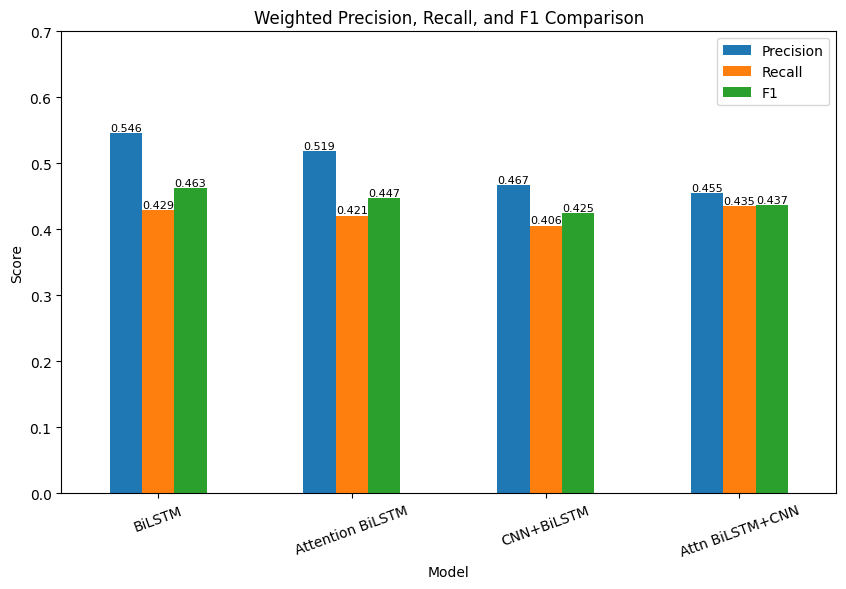

In [26]:
import matplotlib.pyplot as plt
import pandas as pd

# Weighted precision, recall, F1 from your classification reports
results = [
    {"Model": "BiLSTM", "Precision": 0.546, "Recall": 0.429, "F1": 0.463},
    {"Model": "Attention BiLSTM", "Precision": 0.519, "Recall": 0.421, "F1": 0.447},
    {"Model": "CNN+BiLSTM", "Precision": 0.467, "Recall": 0.406, "F1": 0.425},
    {"Model": "Attn BiLSTM+CNN", "Precision": 0.455, "Recall": 0.435, "F1": 0.437},
]

df = pd.DataFrame(results)

# plot grouped bars
ax = df.set_index("Model").plot(kind="bar", figsize=(10,6))
plt.ylim(0,0.7)
plt.ylabel("Score")
plt.title("Weighted Precision, Recall, and F1 Comparison")
plt.xticks(rotation=20)

# annotate each bar
for p in ax.patches:
    ax.annotate(f"{p.get_height():.3f}",
                (p.get_x() + p.get_width()/2, p.get_height()),
                ha='center', va='bottom', fontsize=8)

plt.legend(loc="upper right")
plt.show()